# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [12]:
# 基本的なライブラリ
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [13]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [14]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [15]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [16]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)
    if _X_train.shape[0] < 20:
        return

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-index
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    _risk_test = _model_pipeline.predict(_X_test)
    print(_risk_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    # cumulative/dynamic auc
    _cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    print(_cph_mean_auc)

    # 累積AUCの表示
    plt.subplot(1, 1, 1)
    plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    """
    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )
    """

    df_score = pd.DataFrame(
        [_train_score, _test_score, _cph_mean_auc],
        index=[
            "train c-index",
            "test c-index",
            "AUC mean",
        ],  # "Integrated Brier Score"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [6]:
"""
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"
    
    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            # print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(6, 6))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )

            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )

            try:
                output_result_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                functions.make_dir(output_result_path)
                df_scores.to_csv(output_result_path + "/result.csv")
            except:
                pass

            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            # plt.close()
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show();
"""

In [19]:
def loop_exec():
    # 層別化する特徴量
    subgroup_column = "CLAUDIN_SUBTYPE"
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"
    
    subgroup = "Normal"
 
    # print("subgroup: ", subgroup)
    # init each loop
    plt.figure(figsize=(6, 6))
    df_scores = pd.DataFrame(
        index=["train c-index", "test c-index", "AUC mean"]
    )

    for model_order_dict in model_order_dicts:
        input_data_path = "./{0}/{1}/{2}/{3}".format(
            config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
            config.INTERIM_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
            model_order_dict["model_name"],
        )
        df_score = validate_model(
            model_order=model_order_dict["model_order"],
            val_step=val_step,
            input_data_path=input_data_path,
            output_pipe_path=output_pipe_path,
            is_fitted=False,
        )
        df_scores = pd.merge(
            df_scores, df_score, right_index=True, left_index=True
        )

    try:
        output_result_path = "./{0}/{1}/{2}/{3}".format(
            config.INTERIM_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        functions.make_dir(output_result_path)
        df_scores.to_csv(output_result_path + "/result.csv")
    except:
        pass

    output_fig_path = "./{0}/{1}/{2}/{3}".format(
        config.FIGURES_MODELS_RECURRENCE_DIR,
        subgroup_column,
        subgroup,
        model_order_dict["preprocess_name"],
    )
    functions.make_dir(output_fig_path)
    # plt.close()
    plt.title(subgroup)
    plt.savefig(output_fig_path + "/auc.png")
    plt.show();

  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
[ 0.03899044  0.21961807  0.73054526 -0.01831067  0.14665575  0.20265367
 -0.17680721  0.50921682  0.33761863  0.2995945  -0.08862926  0.03952082
  0.26574154  0.12507752 -0.59014143]
0.6091824830576164
[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625
[15.28561897 23.21289284 25.62582014 16.38800535 20.83394749 22.01404418
 19.09543414 26.99557869 19.15371096 20.19375283 15.98269339 19.27495605
 15.71822765 22.59441476 10.80465156]
0.47429232512237846
[17.11743675 17.63921476 17.71769762 16.80047566 17.43067369 17.67557022
 17.06154122 17.8127185  17.44918293 17.75217431 16.89173496 17.4347253
 17.54785412 17.68869563 16.36554134]
0.6281077556170656
[-0.03321828  0.15128775  0.67659806 -0.0710284   0.07064158  0.08851628
 -0.1378040

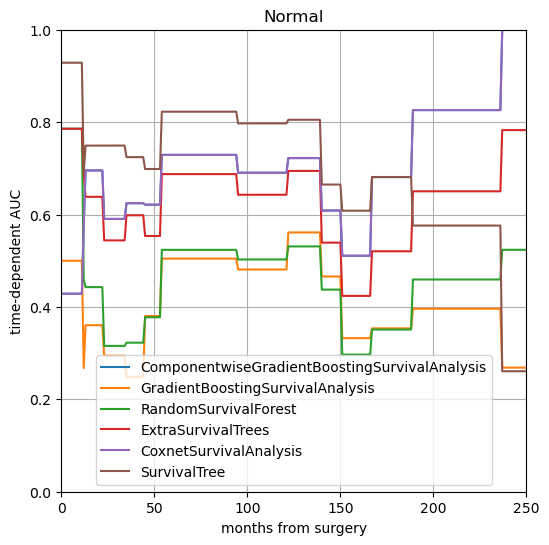

 33%|████████████████████████████▎                                                        | 1/3 [00:19<00:38, 19.02s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
30
[-0.01840244  0.18583653  0.79215285  0.00155503  0.18125412  0.19567636
 -0.06000326  0.55407513  0.3600683   0.26059162 -0.11887044 -0.02037395
  0.31594033  0.20975246 -0.56740544]
0.6967813261643645
[-1.54163126  0.53129164  3.84731864 -1.76393127  3.23511922  2.85763861
  1.60432271  4.73661106  2.67827997 -2.63614551 -1.15036628  0.18464595
 -1.4038449   0.59883323 -4.20922537]
0.5137999469638753
[15.14442787 22.84367814 25.10541524 16.65483663 21.29990651 22.12690024
 18.99731905 26.56028077 19.7678948  19.82389069 15.85398086 18.99599784
 16.73242218 22.28631132 11.54553873]
0.5274424825284784
[16.68514659 17.54655515 17.82765879 16.90472315 17.5483407  17.47075604
 16.96903247 17.8820298  17.43610012 17.42739    16.96833901 17.27231087
 17.70014294 17.48898551 16.64164821]
0.6360091222661686
[-0.03321828  0.15128775  0.67659806 -0.0710284   0.07064158  0.08851628
 -0.1378040

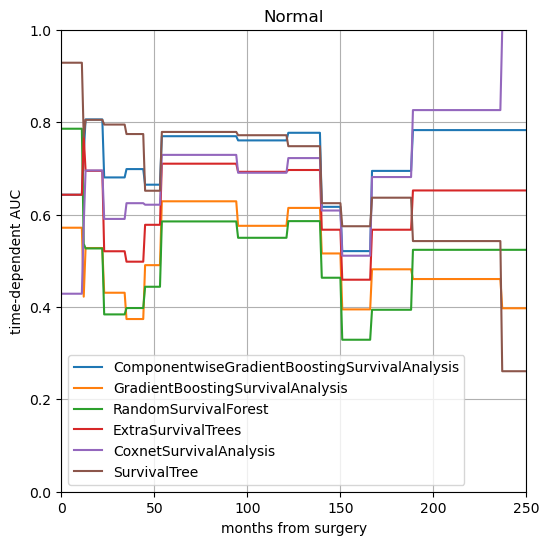

 67%|████████████████████████████████████████████████████████▋                            | 2/3 [00:37<00:18, 18.97s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
31
[-0.01840244  0.18583653  0.79215285  0.00155503  0.18125412  0.19567636
 -0.06000326  0.55407513  0.3600683   0.26059162 -0.11887044 -0.02037395
  0.31594033  0.20975246 -0.56740544]
0.6967813261643645
[-1.54163126  0.53129164  3.84731864 -1.76393127  3.23511922  2.85763861
  1.60432271  4.73661106  2.67827997 -2.63614551 -1.15036628  0.18464595
 -1.4038449   0.59883323 -4.20922537]
0.5137999469638753
[15.14442787 22.84367814 25.10541524 16.65483663 21.29990651 22.12690024
 18.99731905 26.56028077 19.7678948  19.82389069 15.85398086 18.99599784
 16.73242218 22.28631132 11.54553873]
0.5274424825284784
[16.68514659 17.54655515 17.82765879 16.90472315 17.5483407  17.47075604
 16.96903247 17.8820298  17.43610012 17.42739    16.96833901 17.27231087
 17.70014294 17.48898551 16.64164821]
0.6360091222661686
[-0.03321828  0.15128775  0.67659806 -0.0710284   0.07064158  0.08851628
 -0.1378040

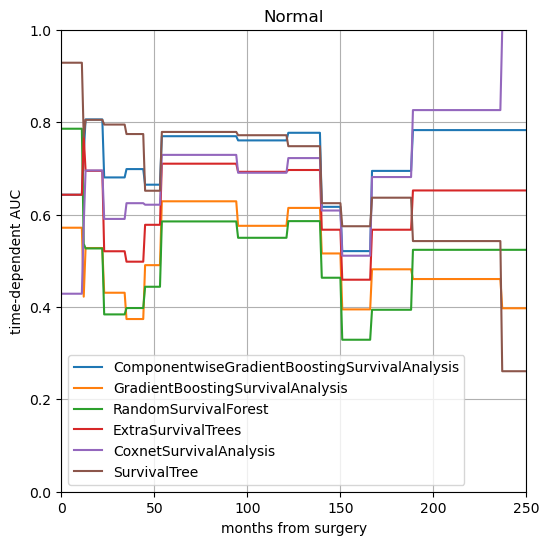

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:56<00:00, 18.83s/it]


In [20]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(29,32, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
        {
            "model_name": CoxnetSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    CoxnetSurvivalAnalysis().__class__.__name__,
                    CoxnetSurvivalAnalysis(n_alphas=10000, fit_baseline_model=True),
                ),
            ],
        },
        {
            "model_name": SurvivalTree().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    SurvivalTree().__class__.__name__,
                    SurvivalTree(random_state=config.SEED),
                ),
            ],
        },
    ]
    loop_exec()

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[-0.66462255  2.21593867 -1.27814462  1.45696547  2.76449852  2.24821757
  0.99409939 -0.20190022  1.84563881 -1.4872144  -1.10543151 -0.22740884
 -2.86862002 -2.4994759   3.28540206  2.06111759 -0.85222293 -2.29601687
 -1.24969264 -2.80664965  2.56744705 -0.203028  ]
nan


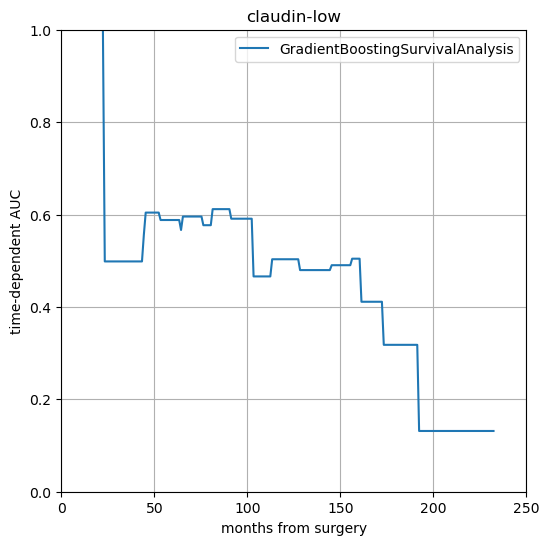

[ 0.81910423 -0.58484384 -0.95913604 -2.3018112  -1.56219809  0.93250135
 -0.87327243  0.18564002  1.24442024 -1.60999113 -1.11712956  2.30353038
 -1.07234573 -0.56338571  0.997924    0.19621639 -0.22702751 -0.58399148
 -0.59322856 -0.40849774  0.150178    0.34805239 -1.04583902  0.01108529
 -1.15205004 -1.0375639  -1.40658384  0.36876524 -1.10959613 -0.15994638
 -0.75289425  1.41856061  0.19988859  0.42653582 -1.91445271  1.0826289
  1.13647902  0.68285639 -0.91364155 -0.58096935 -0.15365437  1.90693158
 -1.1438139   0.81236534  0.2808322   1.00886652  2.19417591 -0.06582985
  1.79697927  0.66783837 -0.53980943  0.43501183 -0.23700754  0.20409208
  1.14055457  0.7487561   0.83525018  0.32674783 -0.16347896  0.54179485
  0.31249431  0.67059009  1.06305821  0.52812711 -1.06762411 -0.38313419
 -0.74068467 -0.07845838 -1.64923572]
0.553528597095901


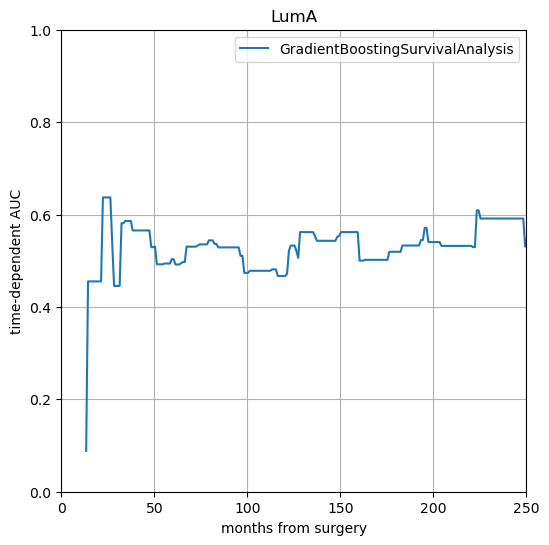

[ 0.21272752 -0.32215311  0.16630748  1.95577856  1.73925862  1.10195455
 -2.35054023 -0.77763882  0.22647233 -0.83464356 -1.2345083  -0.52626951
  0.30845814  1.25271463  2.14934873  0.12254638  0.09900431 -0.95840483
 -0.95572728  0.18676354 -1.78891759  2.06126708 -2.20312203  1.02742418
 -0.52351517 -0.55597651 -1.24912631 -0.56826564  1.00977876 -0.88503086
  1.18006631 -0.59179171 -0.61821216  0.56563572  1.23211081 -0.73985139
  0.4253579   1.13998159  1.36037395 -2.1209076   0.96268123  1.31579767
  1.9802607  -1.4817713  -1.96119203 -2.48570887 -1.00842367 -0.51876672]
0.5722118189801356


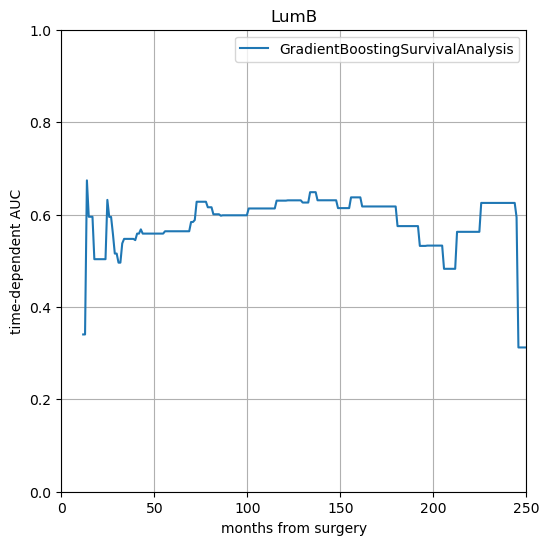

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


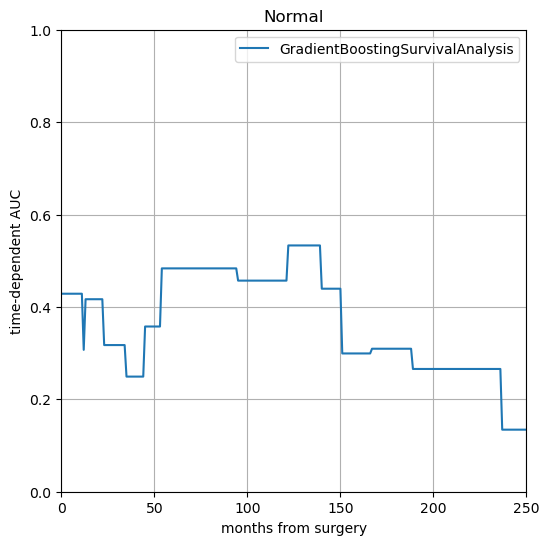

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


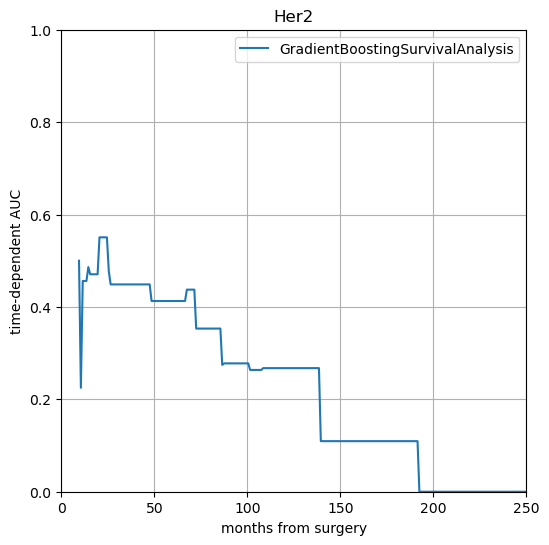

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


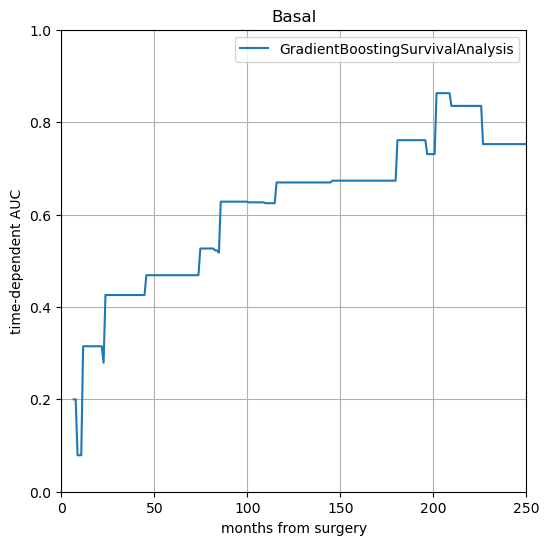

data pkl file dose not exist


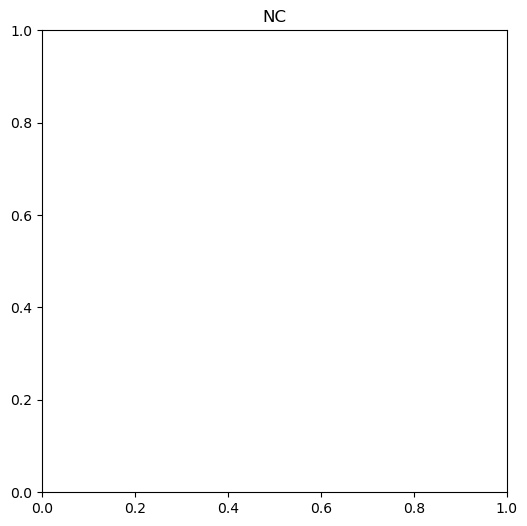

 20%|█████████████████                                                                    | 1/5 [00:15<01:01, 15.27s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
26
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


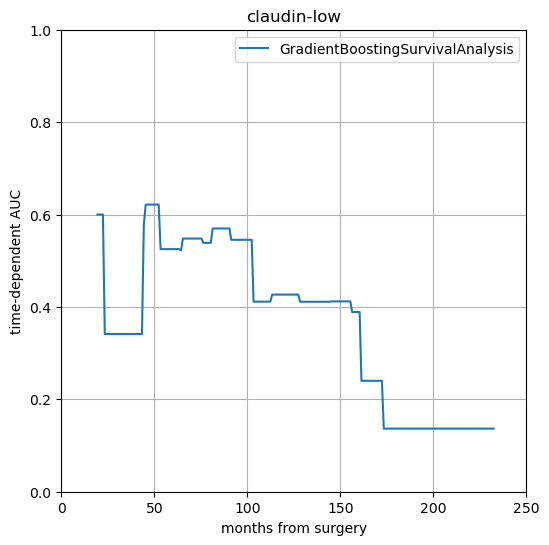

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


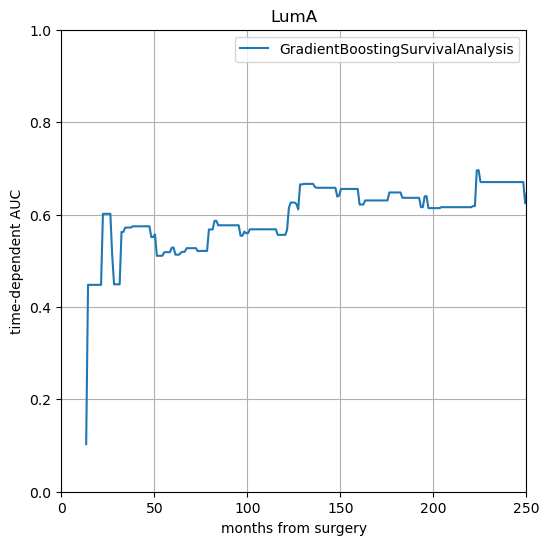

[-0.29816095 -1.37550105 -0.02853549  2.0114589   1.66393582  1.22816119
 -1.48350454 -0.20510831  0.1196093  -0.77380879 -0.46629575  0.06393958
  0.37779217  1.08301354  2.22800792  0.1782986  -0.10879887 -0.26679583
 -1.839408    1.84075266 -2.54185915  3.31476619 -2.05054501  0.86165138
 -0.99669737  0.66222409 -1.9252856  -1.2782884   1.57879547 -1.1672371
  1.55295157 -0.56703377 -0.0603211  -0.39607197 -0.23529291 -0.92975854
  0.91809389  1.3626946   0.04324979 -1.21527289  0.43240992  1.22368563
  1.25254924 -2.38733063 -3.8637504  -3.16976536 -1.81435538 -1.34121186]
0.579269146966861


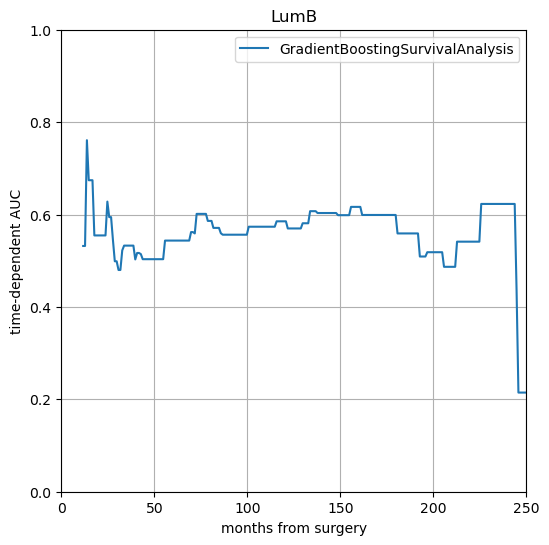

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


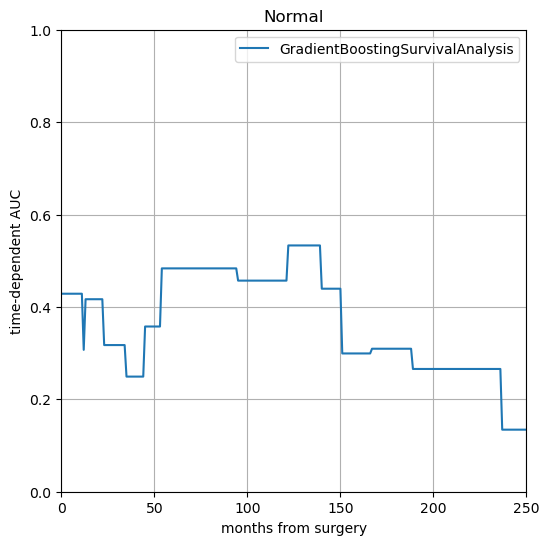

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


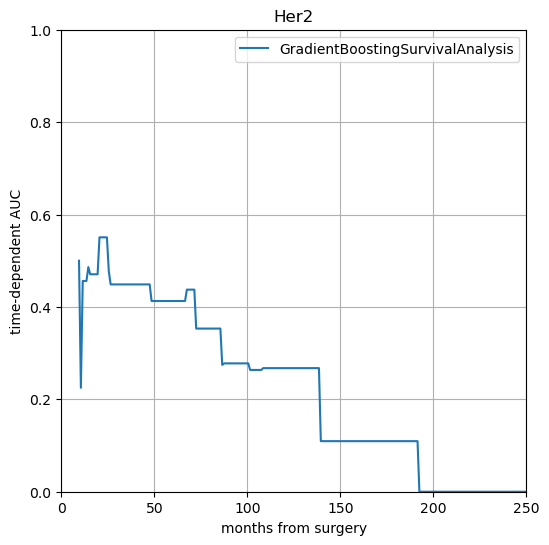

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


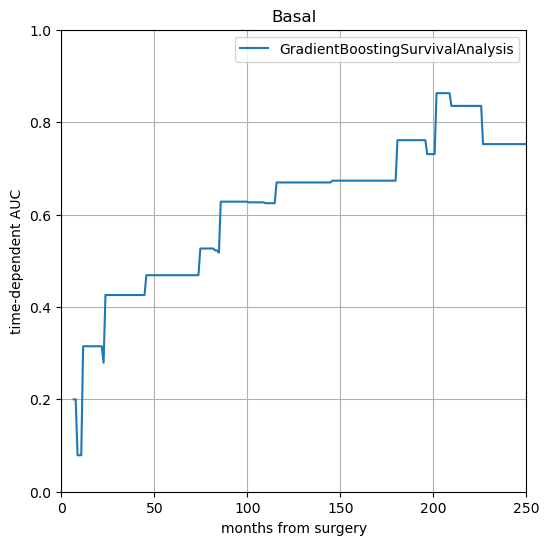

data pkl file dose not exist


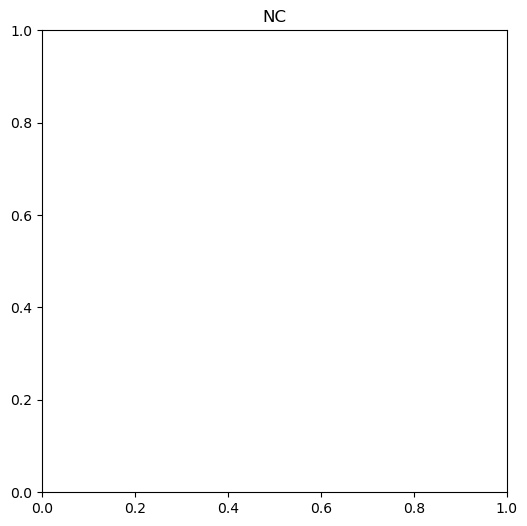

 40%|██████████████████████████████████                                                   | 2/5 [00:25<00:36, 12.19s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
27
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


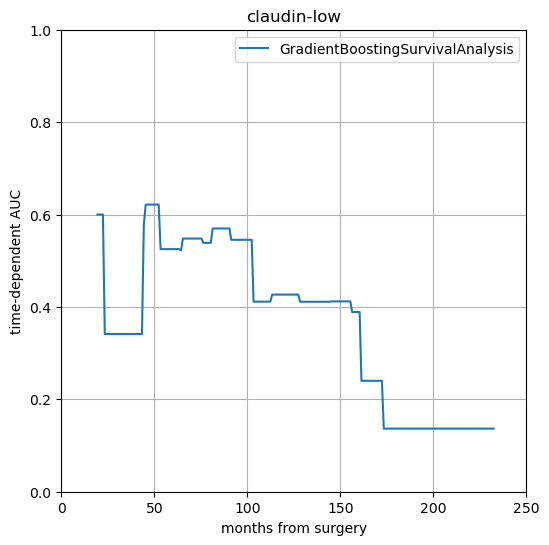

[ 1.1647718  -0.53949264  0.4438762  -1.70980832 -1.54941269  0.80077984
 -1.05099495 -0.15179658  0.84401006 -0.66780516 -1.50551816  1.78093075
 -1.00710227  0.03946767  0.84303905  0.26519874  0.25401803 -0.16249501
 -0.51811747 -0.31855123 -0.09393167  0.62374825 -0.3443578   0.52019119
 -1.37815232 -1.069515   -1.03086422  0.38275894 -1.82158682 -1.08354366
 -0.72341752  1.55322727  0.70841345 -0.55834207 -2.09714071  2.1565477
  0.5031976   0.60478965 -0.76546874  0.43511602  0.30146675  1.14214909
 -0.87733737  0.60440981  1.28289439  0.30904071  1.27869659 -0.0532275
  1.69848755  0.93627411  0.09184524  1.09739257 -0.0333933   0.035852
  0.78272025  0.11357761  1.33186593 -0.26126753  0.02731512 -1.26425058
  0.2255833   0.28592991  1.3726662  -0.05928041 -1.64546081 -0.30889653
 -0.30130764 -0.91933342 -1.42699983]
0.6958686922070627


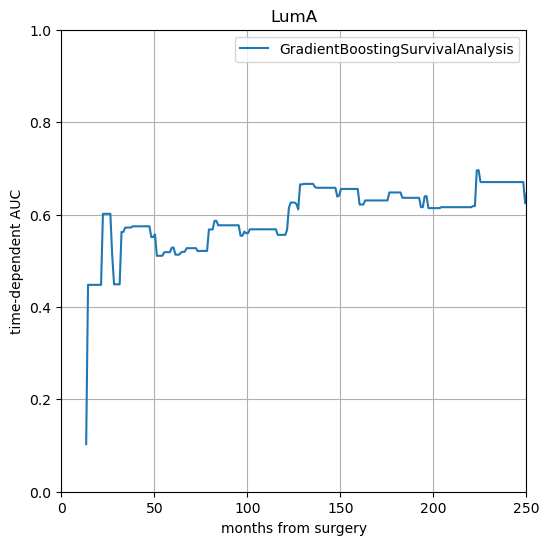

[ 1.64428977 -0.76103864 -0.18748068  2.86509284  1.58245787  0.74890393
 -1.49545217 -0.17286058  0.21275273 -1.02420218 -0.37391356  0.12114964
  0.12581265  1.8086692   2.4658682   0.67607998 -0.21459549 -0.1153092
 -1.79984337  1.27224351 -2.06345232  2.02747614 -1.91230294  0.81348403
  0.18964712 -0.24424723 -1.61392793 -1.08166326  1.56024975 -2.08485317
  0.88786799 -0.59899862 -1.35182685 -0.80349519 -0.16554772 -1.33823589
  0.82039733  1.74852824  0.10308666 -1.17578626  0.3115619   2.33225764
  0.8845358  -2.00924386 -2.44307842 -3.82862556 -1.37270663 -2.10760655]
0.5687912246744259


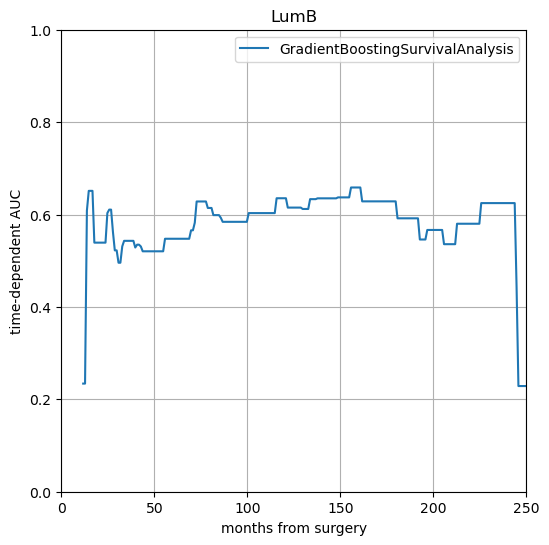

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


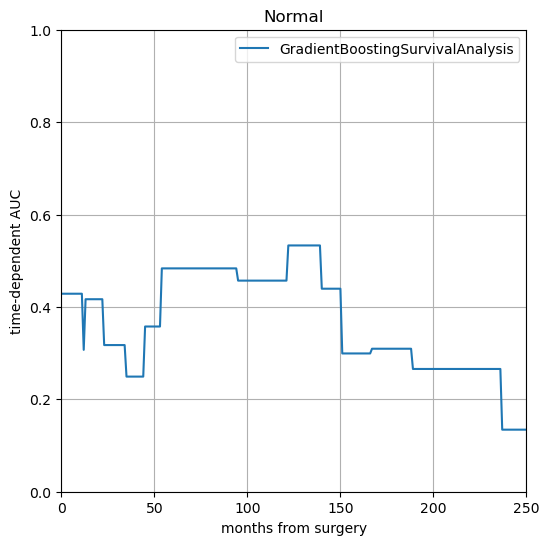

[ 1.34919543 -1.18389027 -1.26579599  0.17816005 -1.16754808 -2.17567451
  3.32885131  0.31683394  3.09045133  2.14762935 -0.80387847 -1.92601247
  0.36578174  2.38212972  1.93157096  0.36036759  0.2851842   0.39983361
 -1.88300049 -0.00970015  3.05880152 -0.18001785  0.72923806]
0.47576321532403243


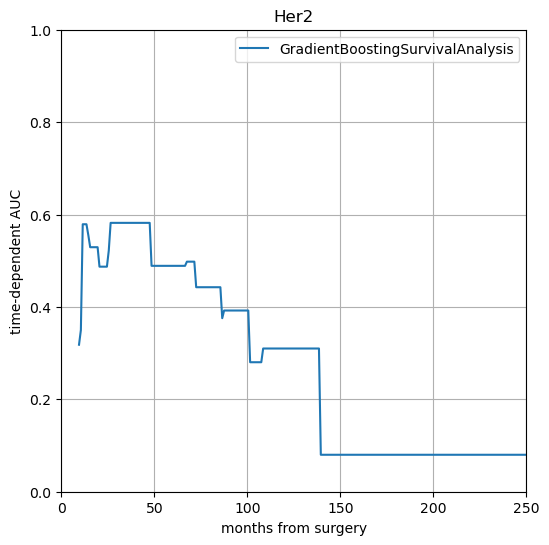

[ 0.68846474 -1.19487744  1.32054531 -0.83613485  0.27150456  2.41322182
  2.27144126 -0.06437624  1.17037912  4.43683958  1.34645155  0.63452683
  2.78674555 -0.94719184 -0.59278584 -2.99379802 -0.07359785 -0.72431269
 -2.5113434  -1.40327955  2.59110329]
0.5842343964857056


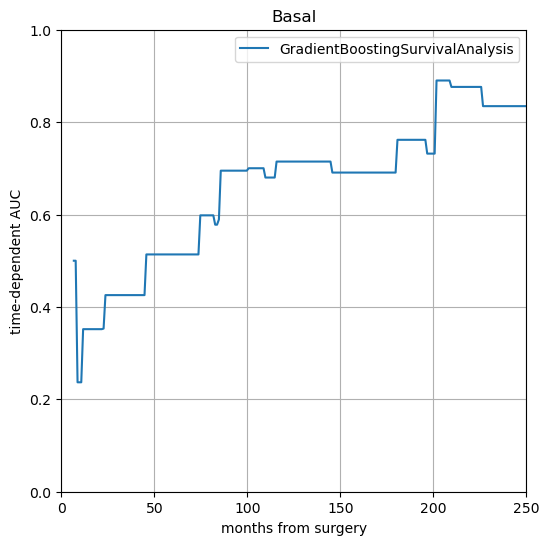

data pkl file dose not exist


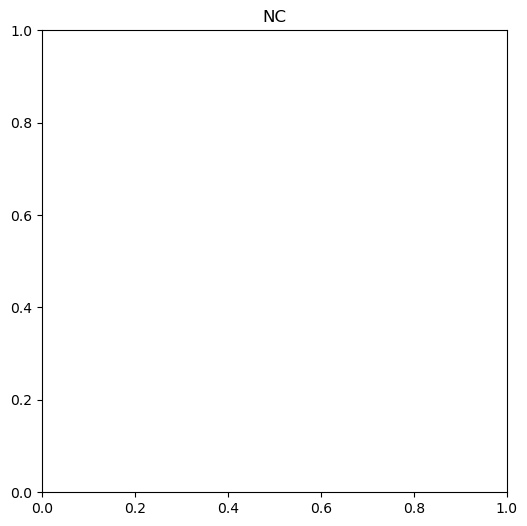

 60%|███████████████████████████████████████████████████                                  | 3/5 [00:35<00:22, 11.31s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
28
[-1.14576879  1.82811708 -1.95989296  3.21972115  3.04524869  2.70589956
  0.47172261 -0.11519645  1.18920182 -3.16071357 -0.22422856  0.39424413
 -2.41667134 -1.0925987   0.4778191   0.60099443  1.47160614 -0.72126573
 -1.32293311 -4.15652442  1.26060702 -1.44496637]
nan


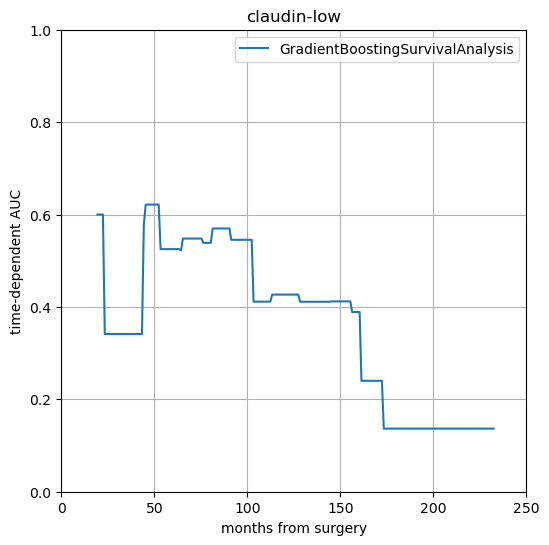

[ 1.10617615 -0.45265927 -0.33802761 -1.46762414 -0.78241575  0.9322115
 -0.49883611 -0.09881251  1.25147795 -0.72838705 -0.50673283  0.85207273
 -1.48214367  0.11318232  1.25221311  0.44299263 -0.21762745  0.34314124
 -0.99491338 -0.49610932 -0.16394825  2.05616793 -0.56744247  0.30301445
 -1.39432312 -1.17714174 -1.32066168  0.09994219 -1.66033633 -0.62327763
 -0.60300316  0.56556577  0.79157991  0.25088545 -2.16851341  2.28507918
  0.74070083  0.10630519 -1.01441445 -0.01415444 -1.32749842  1.11925885
 -1.33491181  0.40356067  0.8768704   0.36878823  1.60011571 -0.25887343
  2.29530142  0.89173059 -0.16457136  1.13094319  0.12744685  0.10523241
  0.87857831  0.13899911  1.05381946  0.26114086 -0.15444825 -1.01459136
  0.42675496  0.34200874  1.35455139 -0.0569336  -1.37614187 -0.34218511
 -0.15855039 -0.66421203 -1.76733485]
0.5701836961105938


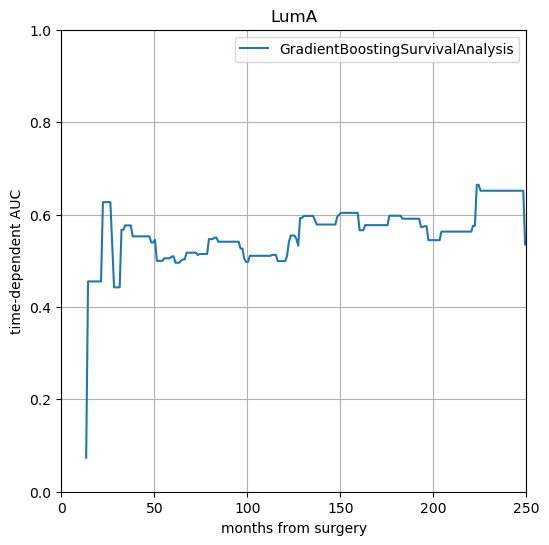

[ 1.7191497  -0.66685647  0.76327452  2.51668866  2.30457919  0.29871587
 -1.1801239   1.0581622   0.34696621 -0.76090491  0.38891632  1.30442354
 -0.00454786  1.97410805  3.32520226  0.62170532  0.52602647  0.66097014
 -2.18166108  0.58514658 -1.90139993  2.95561451 -2.11335523  0.7000122
 -0.57868006 -0.34009371 -1.98021669 -0.89469939  1.37176777 -0.97544648
  1.29085155 -0.86357976 -0.43354325 -0.44701206  0.03258007 -1.43988344
  0.55481938  1.03372136 -0.10825144 -2.1203632   0.28495271  0.54289512
  0.47423777 -2.32884037 -2.26010367 -3.2580263  -1.545901   -1.43237223]
0.5202575052710318


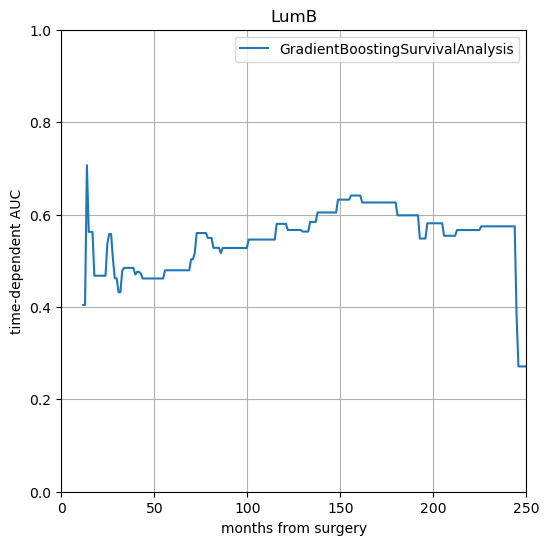

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


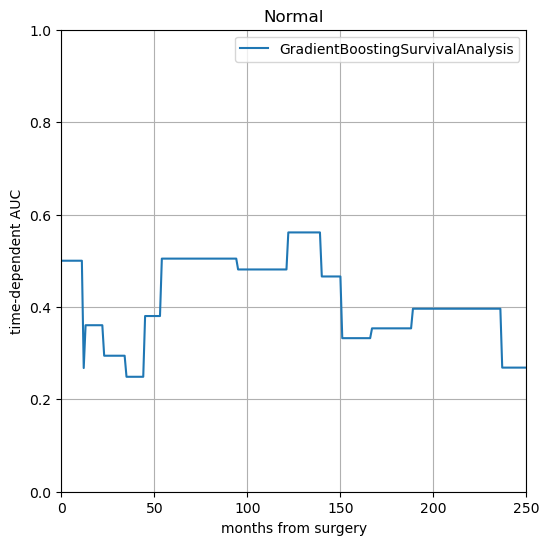

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


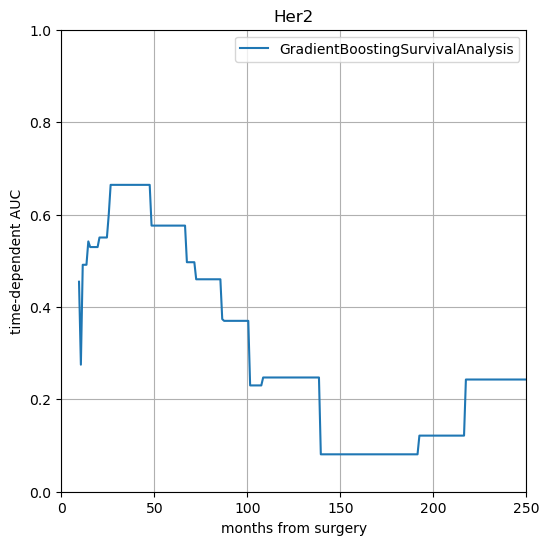

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


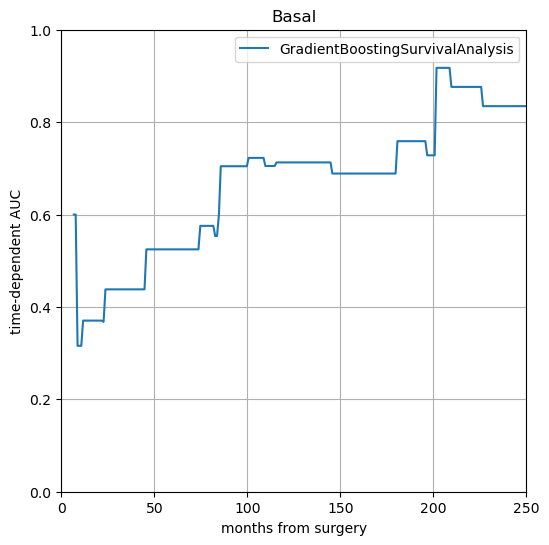

data pkl file dose not exist


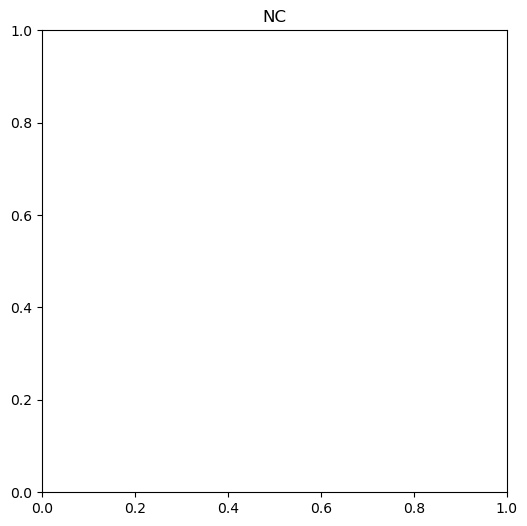

 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:46<00:11, 11.04s/it]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
29
[-0.34636442  1.62586715 -2.02126814  4.04507094  3.72910822  2.34089132
 -0.80610216 -0.56713351  1.42826993 -2.59888449 -0.96971278  2.0356115
 -2.01875026 -1.81423812 -0.5431672   1.43170485  0.35765888 -2.80588969
 -2.16456147 -2.86870926  1.11709408 -1.37231273]
nan


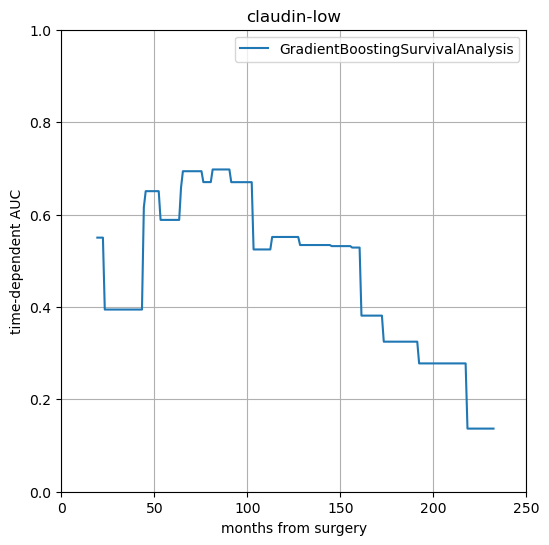

[ 0.64521463 -0.52241969  0.04728249 -1.01568112 -0.26024465  1.34062726
 -1.9349465   0.05875958  1.06386117 -0.69007189 -1.47980258  0.43130659
 -1.43682311  0.24390079  1.17122283  0.72739486 -0.0082983   0.96345143
 -0.73803142 -0.39078375  0.43789474  2.27166809 -0.0388123   0.81503273
 -1.31511735 -0.92543374 -0.96198261  0.11898892 -1.24110203 -0.95495709
 -1.86110433  0.12349721 -0.47840029  0.32687209 -1.815693    2.02388087
  0.93929318  0.41631335 -0.49117073 -0.04247961 -1.83047948  1.16788909
 -1.29839885  0.16700038  1.9062899  -0.61349272  2.26955292 -0.33012923
  1.66347965  0.81227146 -0.74939565  0.9332191   0.1907329   0.37873227
 -1.03679664 -0.72849339  0.10599012  0.75238863 -0.34999436 -1.23180975
  0.64122843  0.56184867  1.39511169  0.02824375 -0.87006382 -0.66031017
  0.12578398  0.66004087 -1.21584388]
0.3773361492970579


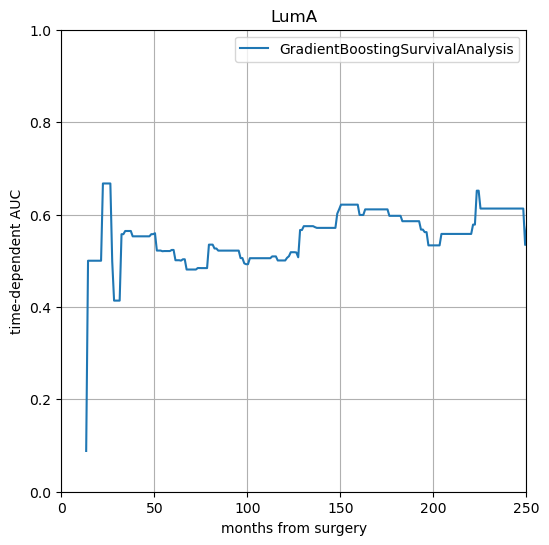

[ 1.41005409  0.01457816  0.66076733  1.52008481  2.16978395 -0.98747827
 -1.12893741  1.33107485  0.57772064 -2.2825947   0.81828288  0.21847421
  0.10310342  2.18177939  2.51747886  0.38334719 -1.45513732  1.87129602
 -1.51401488  0.42463384 -0.83289299  1.06115972 -1.22667311 -0.07324632
 -0.98753913  0.40890379 -1.19338128 -1.86081408  2.05075722  0.4683888
  0.85545663 -1.15977101 -0.93314836 -0.68256008 -0.56411626 -1.51764937
  0.5002916  -0.84389015 -0.43454741 -1.2554608  -1.16385017  2.10999738
  0.2170464  -1.43083836 -0.32663552 -4.40467802 -1.19392753 -2.34677   ]
0.5749231002111117


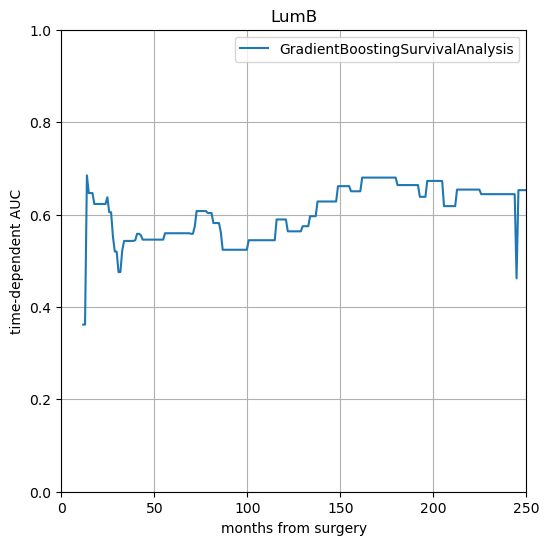

[-1.98669726  2.28946352  1.52728924 -1.18621268  3.18655778  3.70924326
  1.94240186  3.3221282   0.83406232 -2.54777227 -1.46366738 -0.27502787
 -2.56735209  0.13898768 -3.41410953]
0.4016270069248625


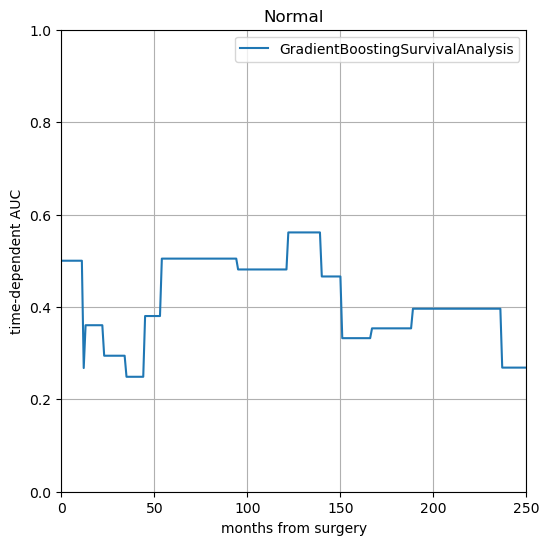

[ 1.77639523 -1.91988973 -2.27689743  0.6832325  -1.76618637 -0.73427336
  2.8247425   1.04227895  5.32478763  2.04341862 -0.62136854 -1.0258449
 -0.69842208  1.29011672  0.42880546 -0.03751928 -1.14721911  0.60118158
 -1.45129288  0.51926737  2.82664289  0.08259001  1.41606465]
0.4996444340372556


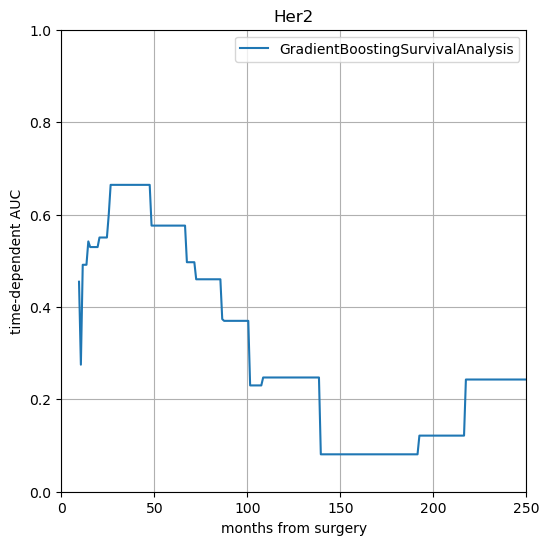

[ 0.74803148 -0.56913885  1.6167754  -0.65310983  0.88290777  2.30777841
  1.99164417 -0.16008121  2.40059367  4.60402103  0.76540465  1.15300215
  2.95152704 -1.31739986 -1.03128464 -2.84901239 -0.45378834 -0.63798402
 -2.88119586 -0.83699931  1.80418106]
0.6116465732232289


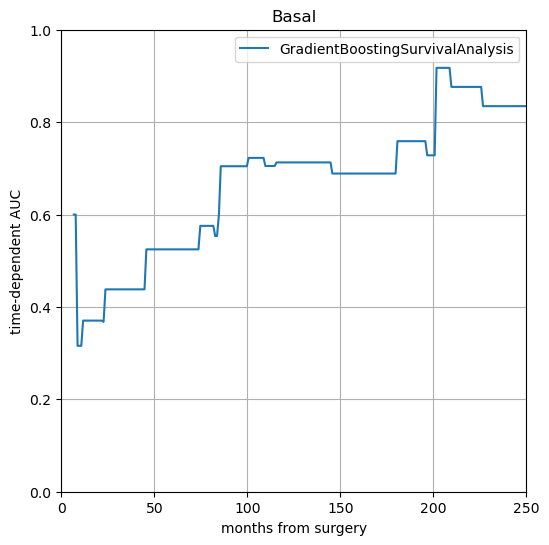

data pkl file dose not exist


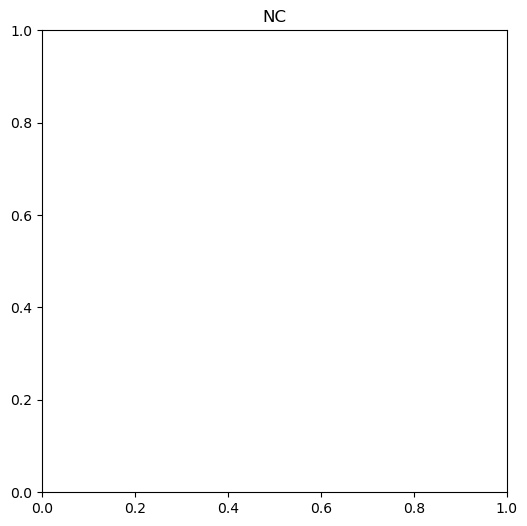

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.27s/it]


In [15]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 30, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__ + "_2",
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [17]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

In [11]:
X.shape

(22, 5)

In [12]:
print("LumA")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("LumB")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Her2")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)


print("claudin-low")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Basal")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

LumA


array([0.07999636, 0.03472473, 0.0332846 , 0.0229756 , 0.02121804,
       0.01845694, 0.0170286 , 0.01643943, 0.01480088])

LumB


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

Her2


array([0.13357718, 0.03192168, 0.02959312, 0.02293049, 0.02194096,
       0.02005952])

claudin-low


array([0.0769747 , 0.05560789, 0.04645281, 0.04078616, 0.03282703])

Basal


array([0.07552512, 0.04812878, 0.03409818, 0.02698724, 0.02222222,
       0.02094353, 0.01901346, 0.01553277])

In [12]:
print("25")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("50")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("77")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca75/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

25


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

50


FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl'

In [1]:
x = np.arange(0, len(pipe[-1].explained_variance_ratio_))
y = pipe[-1].explained_variance_ratio_
plt.title("Matplotlib demo")
plt.xlabel("x axis caption")
plt.ylabel("y axis caption")
# plt.plot(x, y)
plt.plot([0] + list(np.cumsum(y)), "-")
plt.show()

NameError: name 'np' is not defined